In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import warnings

import math

from IPython.display import Image

warnings.filterwarnings('ignore')
%matplotlib inline

In [ ]:
import tensorflow
tensorflow.compat.v1.disable_eager_execution()

# Why VAEs?

When using generative models, you could simply want to generate a random, new output, that looks similar to the training data, and you can certainly do that too with VAEs. But more often, you’d like to alter, or explore variations on data you already have, and not just in a random way either, but in a desired, specific direction. This is where VAEs work better than other method.

In the below example, we can see how the hypothetical embedding space for a standard autoencoder would look like

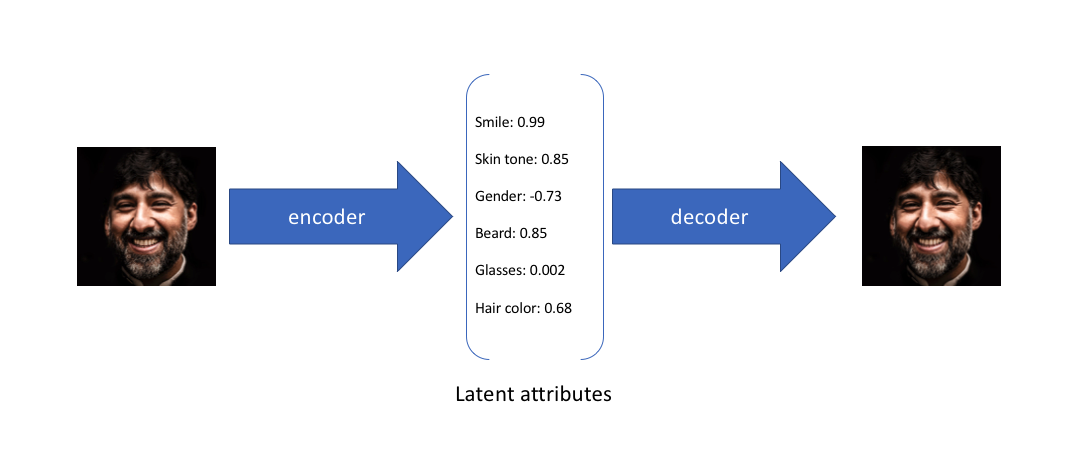



What if we wanted to generate new samples by modifying some attributes of a given sample as follows: 

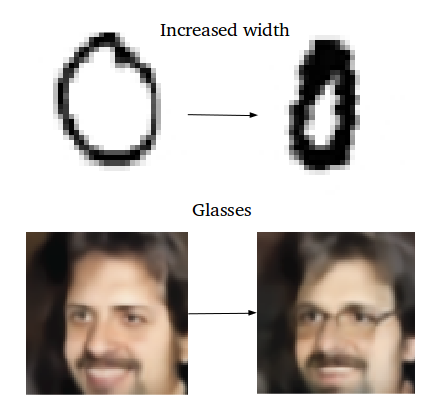

This is not possible with standard autoencoders since the embedding space is discrete as shown in the below figure:

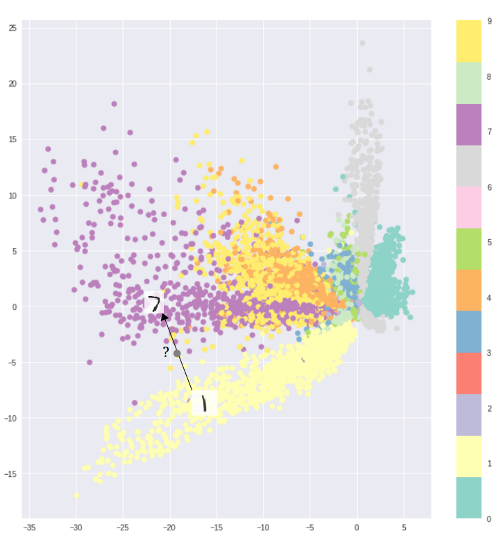

The fundamental problem with autoencoders, for generation, is that the latent space they convert their inputs to and where their encoded vectors lie, may not be continuous, or allow easy interpolation.

If the space has discontinuities (eg. gaps between clusters) and you sample/generate a variation from there, the decoder will simply generate an unrealistic output, because the decoder has no idea how to deal with that region of the latent space. During training, it never saw encoded vectors coming from that region of latent space.

This is where a variational autoencoder comes into the picture. Instead of using the encoder to predict a singular vector, we now predict a distribution (by predicting mean and std dev values for each of the units in the latent dimension). The decoder will now sample inputs from this distribution to decode. This makes the learned feature space continuous.

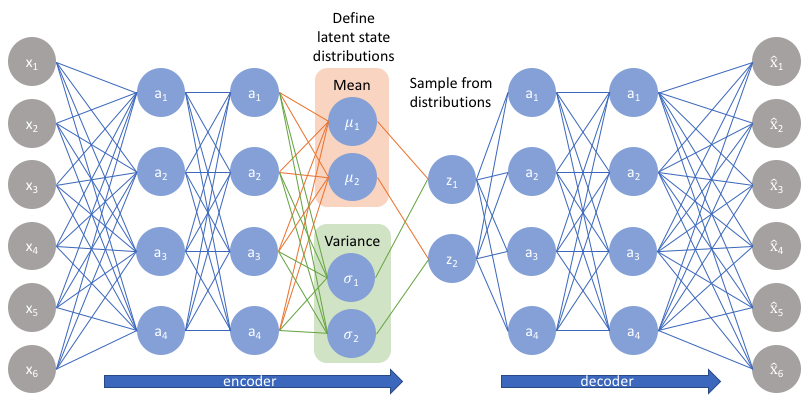

However, the question that now arises is that how to backpropogate while randomly sampling values through a distribution since gradients cannot be computed for random sampling. We overcome this issue using the reparameterization trick as shown below:

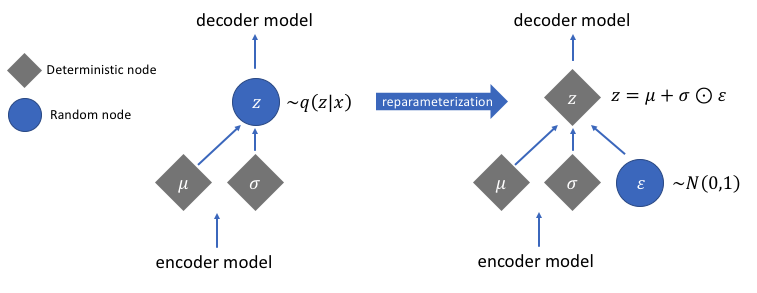

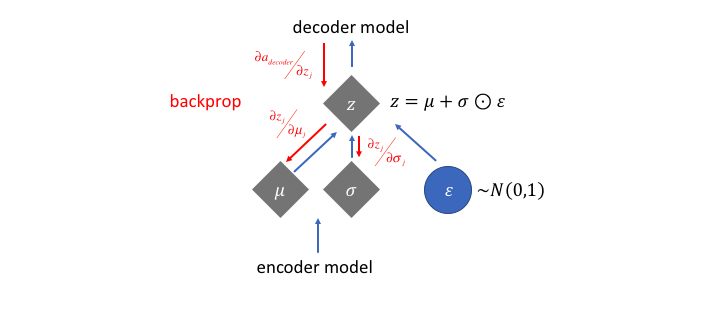

## Loss Function

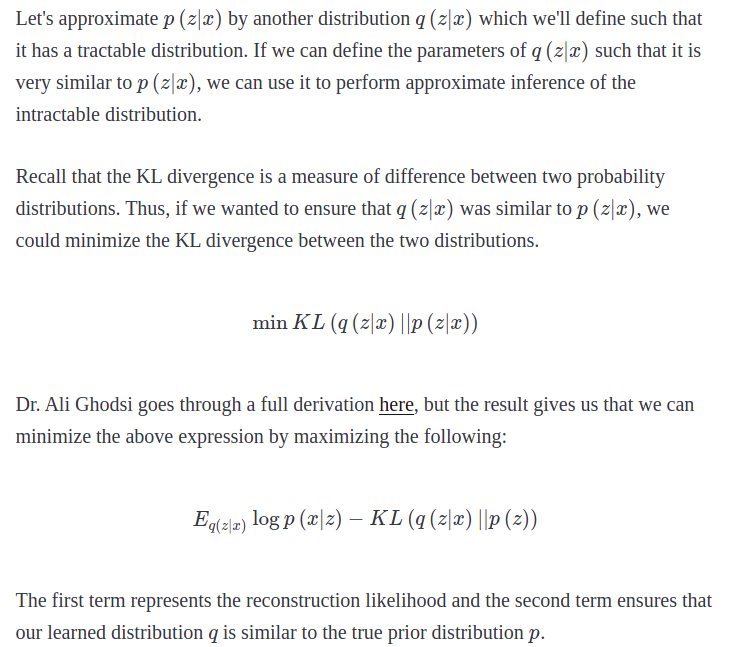

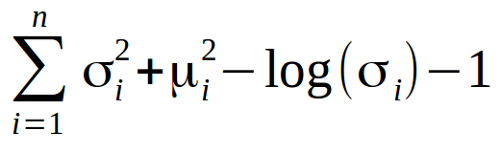

Link to derivation: https://youtu.be/uaaqyVS9-rM?t=19m42s

Finally, if we only use the standard reconstruction loss (MSE), the learned embedding spaces can be further away from each other thus reducing semantic meaning of generating new samples by modifying attributes.
This is why we use KL divergence. 

As we can see below, with the combination of reconstruction loss and KL divergence, the embedding spaces are both closer to each other and continuous. 

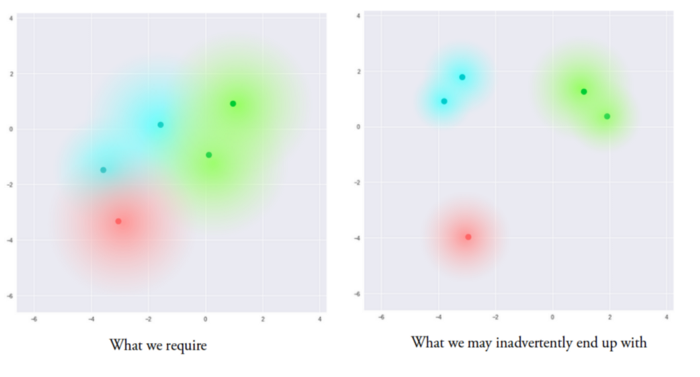

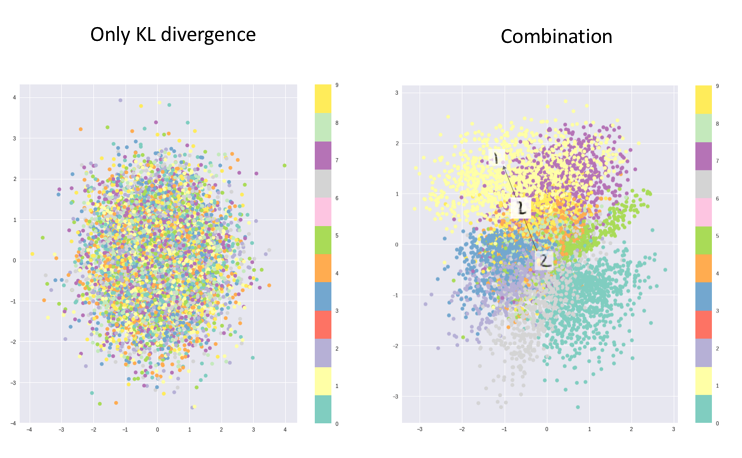

## Applications

Where to from here?
There are plenty of further improvements that can be made over the variational autoencoder. You could indeed, replace the standard fully-connected dense encoder-decoder with a convolutional-deconvolutional encoder-decoder pair, to produce great synthetic human face photos.

You could even train an autoencoder using LSTM encoder-decoder pairs (using a modified version of the seq2seq architecture) for sequential, discrete data (something not possible with methods such as GANs), to produce synthetic text, or even interpolate between MIDI samples such as Google Brain’s Magenta’s MusicVAE. Link: https://nips2017creativity.github.io/doc/Hierarchical_Variational_Autoencoders_for_Music.pdf



# Loading Dataset

11501568/11490434 [==============================] - 0s 0us/step
Training data shapes: X=(60000, 28, 28), y=(60000,)
Testing data shapes: X=(10000, 28, 28), y=(10000,)


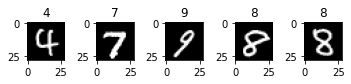

In [ ]:
from tensorflow.keras.datasets import mnist

(trainX, trainy), (testX, testy) = mnist.load_data()

print('Training data shapes: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Testing data shapes: X=%s, y=%s' % (testX.shape, testy.shape))

for j in range(5):
    i = np.random.randint(0, 10000)
    plt.subplot(550 + 1 + j)
    plt.imshow(trainX[i], cmap='gray')
    plt.title(trainy[i])
plt.show()

# Data Preparation

In [ ]:
train_data = trainX.astype('float32')/255
test_data = testX.astype('float32')/255

train_data = np.reshape(train_data, (60000, 28, 28, 1))
test_data = np.reshape(test_data, (10000, 28, 28, 1))

print (train_data.shape, test_data.shape)

(60000, 28, 28, 1) (10000, 28, 28, 1)


# VAE

## Encoder Part

In [ ]:
import tensorflow

input_data = tensorflow.keras.layers.Input(shape=(784,))
encoder = tensorflow.keras.layers.Dense(512, activation='relu')(input_data)
encoder = tensorflow.keras.layers.Dense(16, activation='relu')(input_data)

# TODO: Homework
# input_data = tensorflow.keras.layers.Input(shape=(28, 28, 1))
# Add Conv and MaxPool layers here


# encoder = tensorflow.keras.layers.Flatten()(encoder)
# encoder = tensorflow.keras.layers.Dense(16)(encoder)

## Latent Distribution and Sampling

In [ ]:
def sample_latent_features(distribution):
    distribution_mean, distribution_variance = distribution
    batch_size = tensorflow.shape(distribution_variance)[0]
    random = tensorflow.keras.backend.random_normal(shape=(batch_size, tensorflow.shape(distribution_variance)[1]))
    return distribution_mean + tensorflow.exp(0.5 * distribution_variance) * random

In [ ]:
distribution_mean = tensorflow.keras.layers.Dense(2, name='mean')(encoder)
distribution_variance = tensorflow.keras.layers.Dense(2, name='log_variance')(encoder)
latent_encoding = tensorflow.keras.layers.Lambda(sample_latent_features)([distribution_mean, distribution_variance])

In [ ]:
encoder_model = tensorflow.keras.Model(input_data, latent_encoding)
encoder_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 784)]        0           []                               
                                                                                                  
 dense_1 (Dense)                (None, 16)           12560       ['input_1[0][0]']                
                                                                                                  
 mean (Dense)                   (None, 2)            34          ['dense_1[0][0]']                
                                                                                                  
 log_variance (Dense)           (None, 2)            34          ['dense_1[0][0]']                
                                                                                              

## Decoder Part

In [ ]:
decoder_input = tensorflow.keras.layers.Input(shape=(2))

# Comment out the next 3 lines for homework
decoder = tensorflow.keras.layers.Dense(16)(decoder_input)
decoder = tensorflow.keras.layers.Dense(512)(decoder)
decoder_output = tensorflow.keras.layers.Dense(784, activation='sigmoid')(decoder)

# TODO: Homework
# decoder = tensorflow.keras.layers.Dense(64)(decoder_input)
# decoder = tensorflow.keras.layers.Reshape((1, 1, 64))(decoder)

# Add conv transpose and upsampling2D layers after this: (Eg: decoder = tensorflow.keras.layers.Conv2DTranspose(64, (3,3), activation='relu')(decoder))


In [ ]:
decoder_model = tensorflow.keras.Model(decoder_input, decoder_output)
decoder_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_2 (Dense)             (None, 16)                48        
                                                                 
 dense_3 (Dense)             (None, 512)               8704      
                                                                 
 dense_4 (Dense)             (None, 784)               402192    
                                                                 
Total params: 410,944
Trainable params: 410,944
Non-trainable params: 0
_________________________________________________________________


## Combining

In [ ]:
encoded = encoder_model(input_data)
decoded = decoder_model(encoded)

In [ ]:
autoencoder = tensorflow.keras.models.Model(input_data, decoded)

In [ ]:
autoencoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 model (Functional)          (None, 2)                 12628     
                                                                 
 model_1 (Functional)        (None, 784)               410944    
                                                                 
Total params: 423,572
Trainable params: 423,572
Non-trainable params: 0
_________________________________________________________________


## Loss Function (Reconstruction Loss + KL-loss)

In [ ]:
def get_loss(distribution_mean, distribution_variance):
    
    def get_reconstruction_loss(y_true, y_pred):
        reconstruction_loss = tensorflow.keras.losses.mse(y_true, y_pred)
        reconstruction_loss_batch = tensorflow.reduce_mean(reconstruction_loss)
        return reconstruction_loss_batch*28*28
    
    def get_kl_loss(distribution_mean, distribution_variance):
        kl_loss = 1 + distribution_variance - tensorflow.square(distribution_mean) - tensorflow.exp(distribution_variance)
        kl_loss_batch = tensorflow.reduce_mean(kl_loss)
        return kl_loss_batch*(-0.5)
    
    def total_loss(y_true, y_pred):
        reconstruction_loss_batch = get_reconstruction_loss(y_true, y_pred)
        kl_loss_batch = get_kl_loss(distribution_mean, distribution_variance)
        return reconstruction_loss_batch + kl_loss_batch
    
    return total_loss

## Training

In [ ]:
autoencoder.compile(loss=get_loss(distribution_mean, distribution_variance), optimizer='adam')
autoencoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 model (Functional)          (None, 2)                 12628     
                                                                 
 model_1 (Functional)        (None, 784)               410944    
                                                                 
Total params: 423,572
Trainable params: 423,572
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# TODO: For homework, comment out the next two line.
train_data = train_data.reshape(-1, 784)
test_data = test_data.reshape(-1, 784)

In [ ]:
autoencoder.fit(train_data, train_data, epochs=20, batch_size=64, validation_data=(test_data, test_data))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 10s 161us/sample - loss: 52.1463 - val_loss: 45.5189
Epoch 2/20
60000/60000 [==============================] - 9s 148us/sample - loss: 45.4831 - val_loss: 45.0497
Epoch 3/20
60000/60000 [==============================] - 9s 150us/sample - loss: 45.2516 - val_loss: 45.0714
Epoch 4/20
60000/60000 [==============================] - 9s 149us/sample - loss: 45.1884 - val_loss: 44.9369
Epoch 5/20
60000/60000 [==============================] - 9s 150us/sample - loss: 45.1409 - val_loss: 44.9929
Epoch 6/20
60000/60000 [==============================] - 10s 163us/sample - loss: 45.1106 - val_loss: 45.0007
Epoch 7/20
60000/60000 [==============================] - 10s 161us/sample - loss: 45.0731 - val_loss: 44.8799
Epoch 8/20
60000/60000 [==============================] - 10s 165us/sample - loss: 45.0441 - val_loss: 44.8901
Epoch 9/20
60000/60000 [==============================] - 10s 160u

Real Test Images


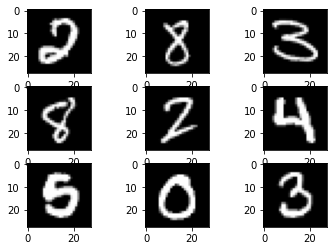

Reconstructed Images with Variational Autoencoder


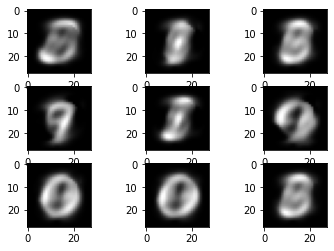

In [ ]:
offset=400
print ("Real Test Images")
# Real Images
for i in range(9):
    plt.subplot(330 + 1 + i)
    # plt.imshow(test_data[i+offset,:,:, -1], cmap='gray')
    reshaped_img = np.reshape(test_data[i+offset,:], (28, 28))
    plt.imshow(reshaped_img,  cmap='gray')
plt.show()

# Reconstructed Images
print ("Reconstructed Images with Variational Autoencoder")
for i in range(9):
    plt.subplot(330 + 1 + i)
    output = autoencoder.predict(np.array([test_data[i+offset]]))
    op_image = np.reshape(output[0]*255, (28, 28))
    plt.imshow(op_image, cmap='gray')
plt.show()

For convolutional VAEs, output will look something like this: 


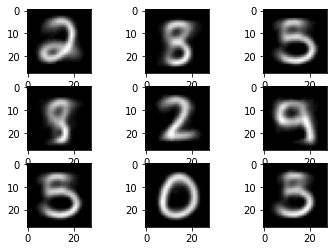

## Latent feature clusters

In [ ]:
x = []
y = []
z = []
for i in range(10000):
    z.append(testy[i])
    op = encoder_model.predict(np.array([test_data[i]]))
    x.append(op[0][0])
    y.append(op[0][1])

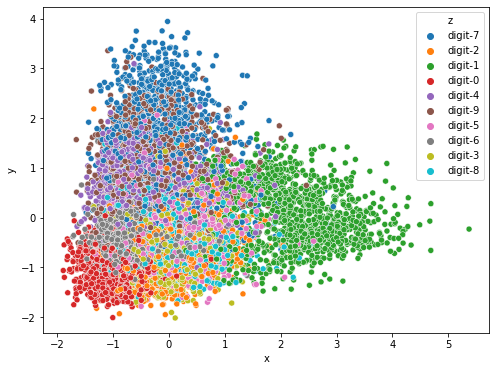

In [ ]:
df = pd.DataFrame()
df['x'] = x
df['y'] = y
df['z'] = ["digit-"+str(k) for k in z]

plt.figure(figsize=(8, 6))
sns.scatterplot(x='x', y='y', hue='z', data=df)
plt.show()

## Image Generation

In [ ]:
generator_model = decoder_model

In [ ]:
x_values = np.linspace(-3, 3, 30)
y_values = np.linspace(-3, 3, 30)

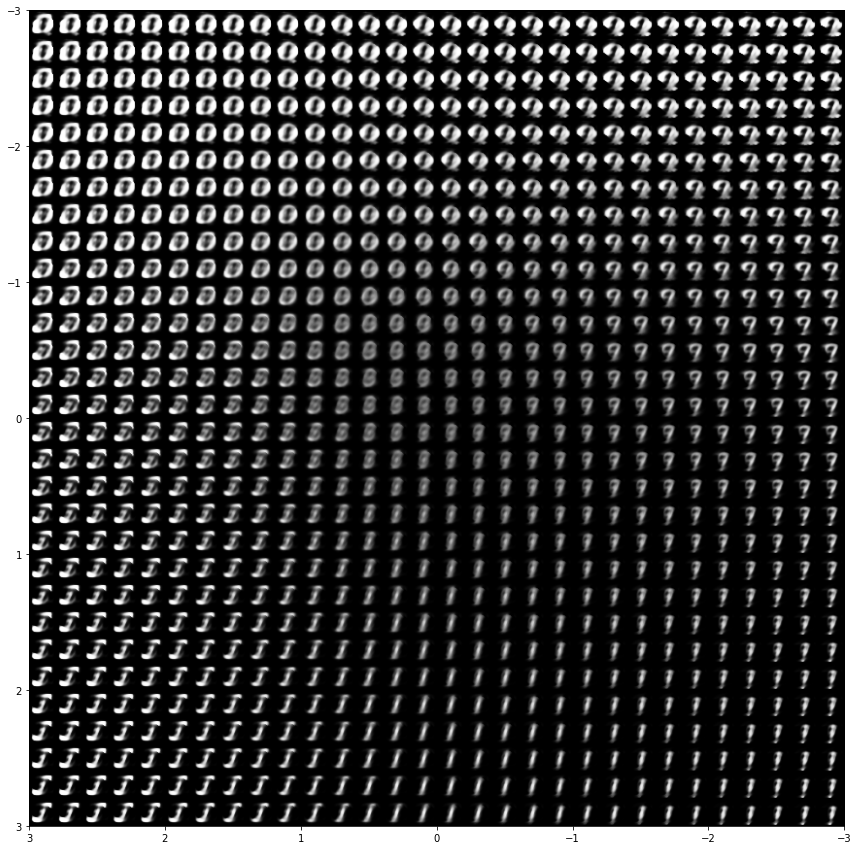

In [ ]:
figure = np.zeros((28 * 30, 28 * 30))
for ix, x in enumerate(x_values):
    for iy, y in enumerate(y_values):
        latent_point = np.array([[x, y]])
        generated_image = generator_model.predict(latent_point)[0]
        reshaped_img = np.reshape(generated_image, (28, 28))
        # figure[ix*28:(ix+1)*28, iy*28:(iy+1)*28,] = generated_image[:,:,-1]
        figure[ix*28:(ix+1)*28, iy*28:(iy+1)*28,] = reshaped_img
 
plt.figure(figsize=(15, 15))
plt.imshow(figure, cmap='gray', extent=[3,-3,3,-3])
plt.show()

For convolutional VAEs, output will look something like this:
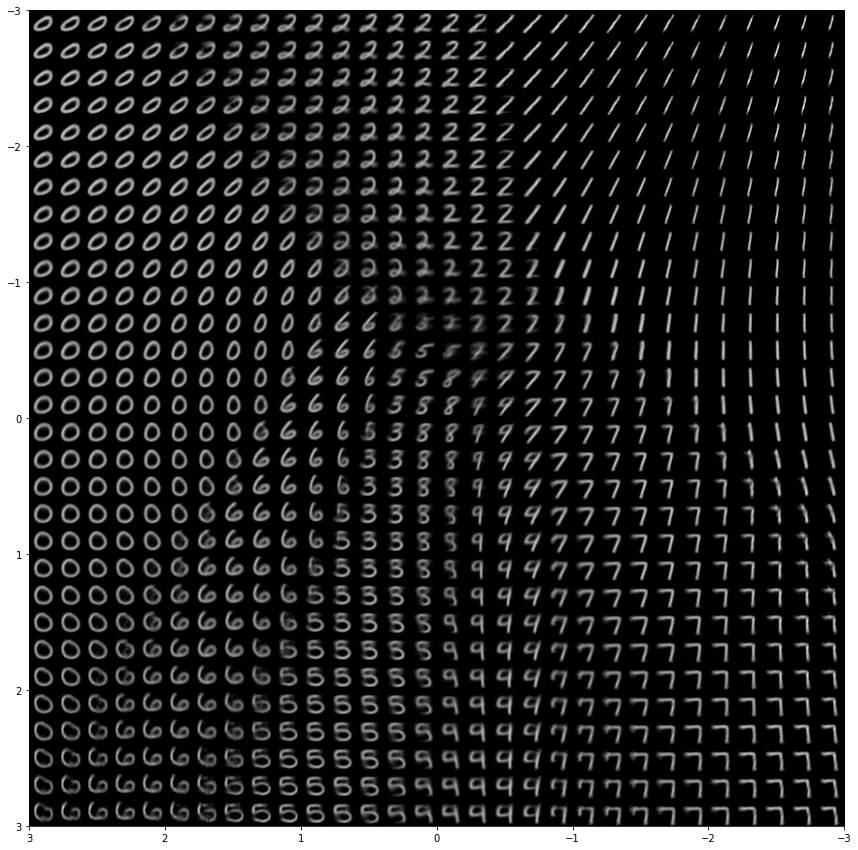

# Homework

Train a variational autoencoder on the Mnist and Fashion-Mnist datasets using a convolutional autoencoders instead of just dense layers and generate the latent embedding space and generated visualizations as shown in the above figures.


Ref: https://towardsdatascience.com/variational-autoencoders-as-generative-models-with-keras-e0c79415a7eb

References:

1. https://www.jeremyjordan.me/variational-autoencoders/
2. https://towardsdatascience.com/intuitively-understanding-variational-autoencoders-1bfe67eb5daf
3. https://towardsdatascience.com/variational-autoencoders-as-generative-models-with-keras-e0c79415a7eb


# Self Organizing Maps

A Self Organizing Map (or Kohonen Map or SOM) is a type of Artificial Neural Network which is also inspired by biological models of neural systems. It follows an unsupervised learning approach and trained its network through a competitive learning algorithm.

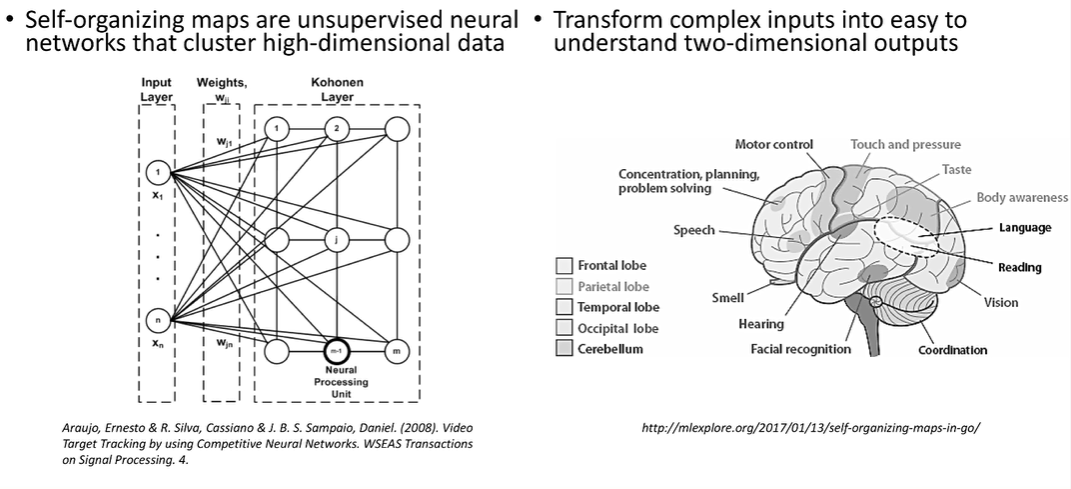

SOM is used for clustering and mapping (or dimensionality reduction) techniques to map multidimensional data onto lower-dimensional which allows people to reduce complex problems for easy interpretation. SOM has two layers, one is the Input layer and the other one is the Output layer.

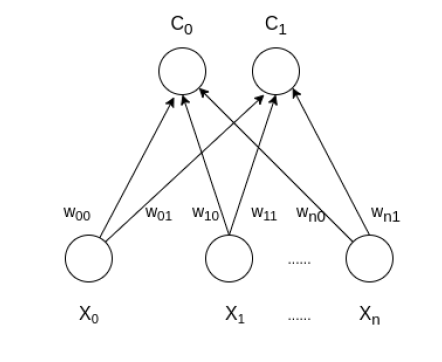

Let’s say an input data of size (m, n) where m is the number of training example and n is the number of features in each example. First, it initializes the weights of size (n, C) where C is the number of clusters. Then iterating over the input data, for each training example, it updates the winning vector (weight vector with the shortest distance (e.g Euclidean distance) from training example).

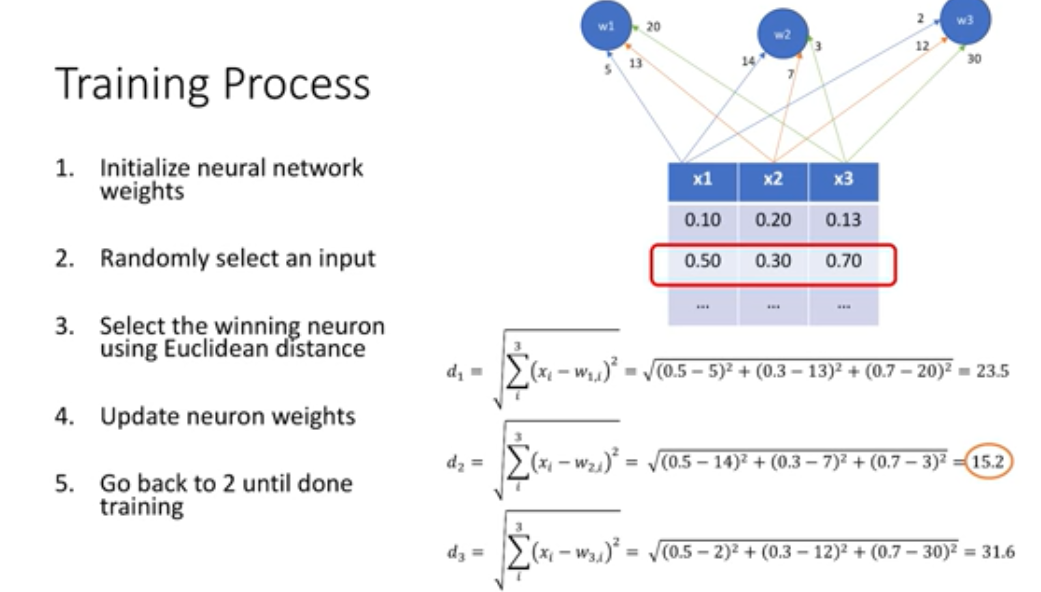

Weights updated as:

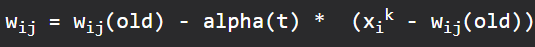

We can also update the weights for all neurons, not just the winning one, as follows:

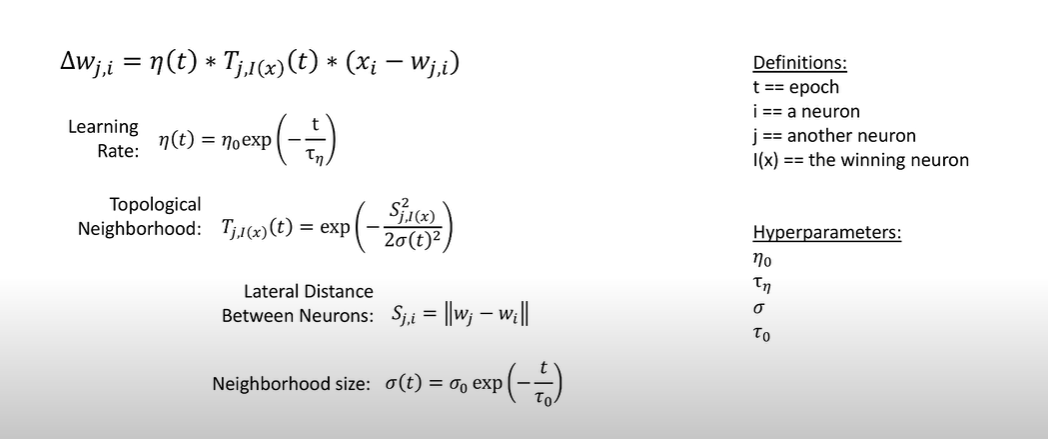

## Example

Dataset: https://www.kaggle.com/ujjwal9/credit-card-applications

### Data Preprocessing

In [ ]:
# import the dataset
dataset = pd.read_csv('/content/Credit_Card_Applications.csv')
X = dataset.iloc [: ,:-1].values    # independent variables
y = dataset.iloc [: , -1].values    # dependent variables

In [ ]:
# feature Scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0,1))
X = sc.fit_transform(X)

### Building The SOM Model

MiniSOM: https://github.com/JustGlowing/minisom

In [ ]:
! pip install -q minisom

# import the SOM model
from minisom import MiniSom

# init the model
som = MiniSom( x = 10, y = 10, input_len = 15, sigma = 1.0, learning_rate = 0.5)  # (x,y) gives the grid, here we have a 10x10 grid

# init the weight
som.random_weights_init(X)

# traing the model
som.train_random(data = X, num_iteration = 100)

###  Visualizing the result

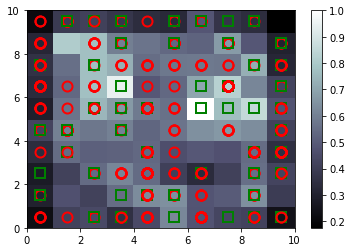

In [ ]:
# making a self organization map
from pylab import bone, pcolor, colorbar, plot, show
bone()
pcolor(som.distance_map().T)
colorbar()
markers = ['o' , 's']
colors = ['r', 'g']
for i, x in enumerate(X):
    w = som.winner(x)
    plot(w[0] + 0.5,
         w[1] + 0.5,
         markers[y[i]],
         markeredgecolor = colors[y[i]],
         markerfacecolor = 'None',
         markersize = 10,
         markeredgewidth = 2)
show()

### Testing It Out

In [ ]:
# mapping the winning node
mappings = som.win_map(X)

In [ ]:
#catch the cheater
frauds = np.concatenate((mappings[(7,8)], mappings[(3,1)], mappings[(5,1)] ) , axis=0)

In [ ]:
# rescale the value using inverse function
frauds = sc.inverse_transform(frauds)

In [ ]:
frauds

array([[1.5786237e+07, 0.0000000e+00, 1.9170000e+01, 5.8500000e-01,
        1.0000000e+00, 6.0000000e+00, 4.0000000e+00, 5.8500000e-01,
        1.0000000e+00, 0.0000000e+00, 0.0000000e+00, 1.0000000e+00,
        2.0000000e+00, 1.6000000e+02, 1.0000000e+00],
       [1.5766183e+07, 0.0000000e+00, 2.4500000e+01, 5.0000000e-01,
        2.0000000e+00, 1.1000000e+01, 8.0000000e+00, 1.5000000e+00,
        1.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        2.0000000e+00, 2.8000000e+02, 8.2500000e+02],
       [1.5767358e+07, 0.0000000e+00, 4.9830000e+01, 1.3585000e+01,
        2.0000000e+00, 4.0000000e+00, 8.0000000e+00, 8.5000000e+00,
        1.0000000e+00, 0.0000000e+00, 0.0000000e+00, 1.0000000e+00,
        2.0000000e+00, 0.0000000e+00, 1.0000000e+00],
       [1.5808662e+07, 0.0000000e+00, 4.6000000e+01, 4.0000000e+00,
        2.0000000e+00, 5.0000000e+00, 3.0000000e+00, 0.0000000e+00,
        1.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        2.0000000e+00,